In [1]:
import tensorflow as tf
import os
import numpy as np
from osgeo import gdal, osr
import cv2
import matplotlib.pyplot as plt

In [7]:
def input_pipeline(filename, batch_size, is_shuffle=True, is_train=True, is_repeat=True):
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([400*400*4], dtype=tf.int64),
        'label': tf.io.FixedLenFeature([400*400*1], dtype=tf.int64),
    }

    def _parse_function(example_proto):
        feature_dict = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(feature_dict['image_raw'], [400, 400, 4])
        image = tf.cast(image, tf.float32)

        image = image/10000

        label = tf.reshape(feature_dict['label'], [400, 400, 1])
        label = tf.cast(label, tf.float32)

        image_label = tf.concat([image, label], axis=-1)
        if is_train:
            image_label = tf.image.rot90(image_label, tf.random.uniform([], 0, 5, dtype=tf.int32))
            image_label = tf.image.random_flip_left_right(image_label)
            image_label = tf.image.random_flip_up_down(image_label)

        image = image_label[:, :, :4]
        label = image_label[:, :, -1]

        label = tf.cast(label, tf.int32)

        return image, label

    dataset = tf.data.TFRecordDataset(filename)
    if is_repeat:
        dataset = dataset.repeat()
    dataset = dataset.map(_parse_function)
    if is_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    batch = dataset.batch(batch_size=batch_size)
    return batch

In [2]:
from transformers import TFSegformerForSemanticSegmentation

def segmentor():
    inputs = tf.keras.layers.Input(shape=[None, None, 4])

    base_model = TFSegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b0",
        num_labels=2,
        ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
    )

    bs = tf.shape(inputs)[0]
    height = tf.shape(inputs)[1]
    width = tf.shape(inputs)[2]
    band =  tf.shape(inputs)[3]

    inputs_ = tf.reshape(inputs, [bs, height, width, band])
    inputs_ = tf.transpose(inputs_, [0, 3, 1, 2])
    inputs_ = tf.reshape(inputs_, [-1, band, height, width])
    x = inputs_

    x = base_model(inputs_[:, :3, :, :])
    x_logits = tf.transpose(x.logits, [0, 2, 3, 1])
    x_logits = tf.image.resize(x_logits, (height, width))

    print(x_logits.shape)

    return tf.keras.Model(inputs=inputs, outputs=x_logits)

In [3]:
BATCH_SIZE = 20
u_optimizer = tf.keras.optimizers.Adam(1e-4)
u_model = segmentor()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model 

(None, None, None, 2)


In [8]:
def train_step(t_images, t_labels):
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    with tf.GradientTape() as u_tape:
        prob = u_model(t_images, training=True)
        loss = ce_loss(t_labels, prob)
    gradients_of_u_model = u_tape.gradient(loss, u_model.trainable_variables)
    u_optimizer.apply_gradients(zip(gradients_of_u_model, u_model.trainable_variables))
    return prob


def train(train_ds, epoch):
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    for (t_images, t_labels) in train_ds:

        logits = train_step(t_images, t_labels)
        train_accuracy.update_state(t_labels, logits)
        # print(train_accuracy.result())

    train_acc = train_accuracy.result()
    print('train accuracy over epoch %d: %.2f'% (epoch+1, train_acc*100))

    return

In [6]:
folder = ['/content/drive/MyDrive/ice_cloud/l8ps_ds_2', '/content/drive/MyDrive/ice_cloud/l8ps_ds_3',
          '/content/drive/MyDrive/ice_cloud/l8ps_ds_4', '/content/drive/MyDrive/ice_cloud/l8ps_ds_5', '/content/drive/MyDrive/ice_cloud/l8ps_ds_6']
filenames = [os.path.join(folder[0], f) for f in os.listdir(folder[0]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[1], f) for f in os.listdir(folder[1]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[2], f) for f in os.listdir(folder[2]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[3], f) for f in os.listdir(folder[3]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[4], f) for f in os.listdir(folder[4]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]
filenames

['/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230308_212634_27_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230325_103503_19_240c.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230329_033637_63_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230402_144322_97_2402.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230417_072528_39_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094613_93_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094636_32_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230420_143108_00_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192205_75_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192219_98_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230503_122053_44_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230515_223754_57_240c.tfrecords',
 '/content/drive/MyDrive/ice

In [ ]:
def train_process():
    train_ds = input_pipeline(filenames, BATCH_SIZE, is_repeat=False)

    for i in range(20):
        train(train_ds, i)
        if (i + 1) % 1 == 0:
            u_model.save_weights('segformer.ckpt')

train_process()

In [11]:
u_model.load_weights('/content/drive/MyDrive/ice_cloud/github_code/Segformer.ckpt')

In [5]:
def tif2array(input_file):
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=int)

    for b in range(dataset.RasterCount):
        band = dataset.GetRasterBand(b + 1)
        image[:, :, b] = band.ReadAsArray()

    return image

In [12]:
folder_path = '/content/drive/MyDrive/ice_cloud/test_ds/dataset'
imgs = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs.sort()

folder_path = '/content/drive/MyDrive/ice_cloud/test_ds2/dataset'
imgs2 = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs2.sort()
imgs = imgs+imgs2
imgs

['/content/drive/MyDrive/ice_cloud/test_ds/dataset/2022-04-15_strip_5573346_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-08-31_strip_6747657_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-09_strip_6763305_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-14_strip_6774056_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-20_strip_6786319_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-21_strip_6788017_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-24_strip_6793653_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-27_strip_6800261_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-06_strip_6818915_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-08_strip_6823217_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-13_strip_6833728_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/202

In [13]:
def clip_center(img, clip_height, clip_width):
    """
    Clips the center part of the image.

    Parameters:
    - img: 2D or 3D NumPy array representing the image.
    - clip_height: Height of the central clip.
    - clip_width: Width of the central clip.

    Returns:
    - Clipped center part of the image as a NumPy array.
    """
    # Get image dimensions
    img_height, img_width = img.shape[:2]

    # Calculate the center coordinates
    center_y, center_x = img_height // 2, img_width // 2

    # Define the starting and ending points for the clipping
    start_y = max(center_y - clip_height // 2, 0)
    end_y = min(center_y + clip_height // 2, img_height)
    start_x = max(center_x - clip_width // 2, 0)
    end_x = min(center_x + clip_width // 2, img_width)

    # Return the clipped center part
    return img[start_y:end_y, start_x:end_x]

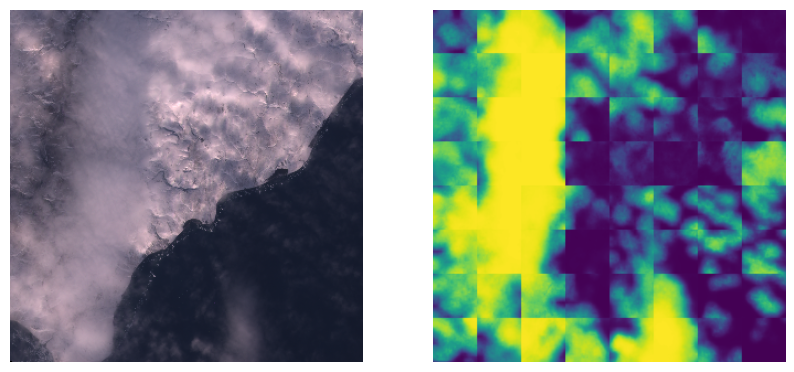

In [21]:
for img_path in imgs[2:3]:
    img = tif2array(img_path)
    img = clip_center(img, 3200, 3200)

    img = img/10000

    img = tf.reshape(img, [1, 3200, 3200, 4])

    patch_size = 400
    stride = 400
    output_shape = (img.shape[1], img.shape[2])  # (3200, 3200) in this case

    full_prediction = np.zeros(output_shape)

    for i in range(0, img.shape[1], stride):
        for j in range(0, img.shape[2], stride):
            patch = img[:, i:i+patch_size, j:j+patch_size, :]

            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:

                paddings = tf.constant([[0, 0], [32, 32], [32, 32], [0, 0]])
                pred = u_model(tf.pad(patch, paddings, "SYMMETRIC"), training=False)
                pred = tf.image.resize_with_crop_or_pad(pred, 400, 400)
                pred = tf.nn.softmax(pred, axis=-1)  # segformer use, not deeplab

                full_prediction[i:i+patch_size, j:j+patch_size] = pred[0, :, :, 1]

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow((img[0, ::10, ::10, 2::-1]), vmin=0, vmax=1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow((full_prediction), vmin=0, vmax=1)
